# Generate Data

In [1]:
# Imports
from pathlib import Path
from tqdm import tqdm
from elements import elements
from mendeleev import element

from Code.cifSimulation import structureGenerator
from Code.h5Constructor import h5Constructor

import cProfile

## Cif generation

In [2]:
# Path to dataset
datasetPath = './Dataset/CIFs/SimulatedTest2/'

# Initialize the CIF generator
generator = structureGenerator()

# Maximum number of atom species in generated structures
n_species = 2

# Choose required atoms to use
required_atoms = ['O']

# Choose optional atoms to use
metals = [atom.Symbol for atom in elements.Alkali_Metals] 
metals += [atom.Symbol for atom in elements.Alkaline_Earth_Metals] 
metals += [atom.Symbol for atom in elements.Transition_Metals] 
metals += [atom.Symbol for atom in elements.Metalloids] 
metals += [atom.Symbol for atom in elements.Others]

optional_atoms = []
for metal in metals:
    try:
        elm_data = element(metal)
        if elm_data.metallic_radius or elm_data.atomic_radius:
            optional_atoms.append(metal)
        else:
            print(f'Removed {metal} from dataset as no table values were available.')
    except:
        print(f'Removed {metal} from dataset as no table values were available.')
optional_atoms = ['Zn', 'Nb']

# Simulate mono-metal oxides
generator.create_cif_dataset(
    n_species=n_species,
    required_atoms=required_atoms,
    optional_atoms=optional_atoms,
    from_table_values=False,
    save_folder=datasetPath,
)

Removed Fr from dataset as no table values were available.
Removed Bh from dataset as no table values were available.
Removed Db from dataset as no table values were available.
Removed Hs from dataset as no table values were available.
Removed Mt from dataset as no table values were available.
Removed Rf from dataset as no table values were available.
Removed Sg from dataset as no table values were available.
Removed Uub from dataset as no table values were available.
Removed Uun from dataset as no table values were available.
Removed Uuu from dataset as no table values were available.


Calculating cell parameter approximations: 100%|██████████| 14/14 [01:48<00:00,  7.78s/it]


Simulating CIFs


Structure types: 100%|██████████| 14/14 [00:07<00:00,  1.99it/s]


## .h5 generation

In [3]:
gc = h5Constructor(cif_dir='./Dataset/CIFs/SimulatedTest2/', save_dir='./Dataset/h5/SimulatedTest2/')
# cProfile.run('gc.gen_h5s(parallelize=False, device="cuda")', sort='tottime')
gc.gen_h5s(parallelize=False, device='cuda', np_radii=[5,10])

CadmiumChloride_NbO2
CadmiumIodide_ZnO2
Fluorite_NbO2
Spinel_NbNb2O4
Wurtzite_NbO
RockSalt_NbO
Wurtzite_ZnO
NickelArsenide_NbO
CaesiumChloride_ZnO
CadmiumIodide_NbO2
NickelArsenide_ZnO
Rutile_ZnO2
AntiFluorite_Zn2O
ZincBlende_ZnO
AntiFluorite_Nb2O
Spinel_ZnZn2O4
Rutile_NbO2
CaesiumChloride_NbO
RheniumTrioxide_ZnO3
RockSalt_ZnO
CadmiumChloride_ZnO2
RheniumTrioxide_NbO3
Fluorite_ZnO2
ZincBlende_NbO


## Misc

In [9]:
from mendeleev import element
from mendeleev.fetch import fetch_table
element('Zn').electron_affinity

In [13]:
affinity_list = fetch_table('elements')[['symbol', 'electron_affinity']]

In [14]:
affinity_list[affinity_list['electron_affinity'].isnull()]

,symbol,electron_affinity
9,Ne,NaN
11,Mg,NaN
24,Mn,NaN
29,Zn,NaN
35,Kr,NaN
47,Cd,NaN
60,Pm,NaN
61,Sm,NaN
63,Gd,NaN
66,Ho,NaN


# Load and inspect data

In [12]:
from Code.datasetClass import InOrgMatDatasets
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore') # , category=FutureWarning

test = InOrgMatDatasets('Simulated', root='./Dataset/')

In [13]:
test.create_data_split()
test.create_data_split(split_strategy='stratified', stratify_on='Crystal type')

In [14]:
test.load_data_split(split_strategy='stratified', stratify_on='Crystal type')

In [106]:
print(test.len())
test.get(135)

3240


Data(
  x=[8, 4],
  edge_index=[2, 32],
  edge_attr=[32],
  y={
    crystal_type='ZincBlende',
    space_group_symbol='F -4 3 m',
    space_group_number=216,
    atomic_species=[2],
    n_atomic_species=2,
    cell_params=[6],
    np_size=11.891290664672852,
    nd=[2, 290],
    xrd=[2, 290],
    nPDF=[2, 5500],
    xPDF=[2, 5500],
    sans=[2, 300],
    saxs=[2, 300],
  },
  pos=[8, 3],
  pos_real=[8, 3]
)

In [83]:
print(test.len(split='train'), test.len(split='validation'), test.len(split='test'))
test.get(1, split='test')

1944 648 648


Data(
  x=[4, 4],
  edge_index=[2, 8],
  edge_attr=[8],
  y={
    crystal_type='Wurtzite',
    space_group_symbol='C m c 21',
    space_group_number=36,
    atomic_species=[2],
    n_atomic_species=2,
    cell_params=[6],
    np_size=53.7194709777832,
    nd=[2, 290],
    xrd=[2, 290],
    nPDF=[2, 5500],
    xPDF=[2, 5500],
    sans=[2, 300],
    saxs=[2, 300],
  },
  pos=[4, 3],
  pos_real=[4, 3]
)

In [107]:
test.get(1, split='val')

Data(
  x=[4, 4],
  edge_index=[2, 6],
  edge_attr=[12],
  y={
    crystal_type='ReO3',
    space_group_symbol='P m -3 m',
    space_group_number=221,
    atomic_species=[2],
    n_atomic_species=2,
    cell_params=[6],
    np_size=22.391328811645508,
    nd=[2, 290],
    xrd=[2, 290],
    nPDF=[2, 5500],
    xPDF=[2, 5500],
    sans=[2, 300],
    saxs=[2, 300],
  },
  pos=[4, 3],
  pos_real=[4, 3]
)

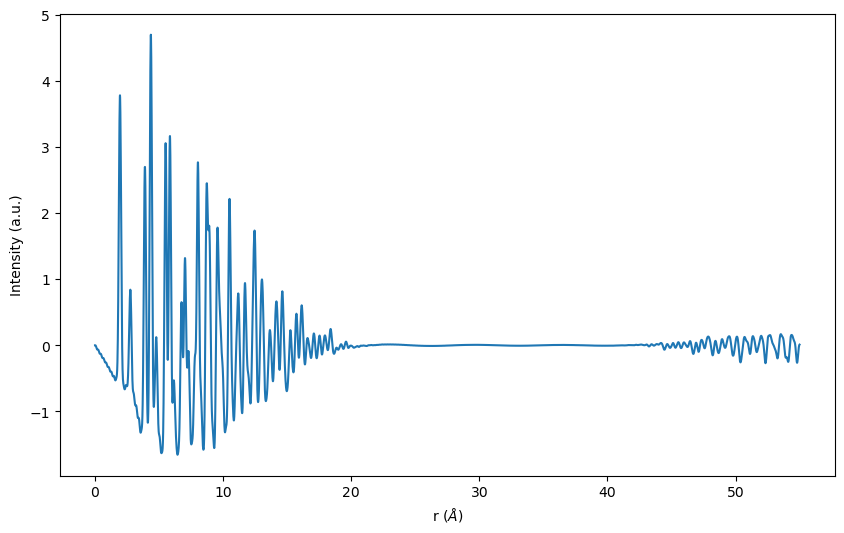

In [105]:
plt.figure(figsize=(10, 6))
plt.plot(*test.get(1, split='val').y['xPDF'])
plt.ylabel('Intensity (a.u.)')
plt.xlabel('r ($\AA$)')
plt.show()

In [17]:
stats = test.get_statistics(return_dataframe=True)
stats.head()

,idx,# of nodes,# of edges,# of elements,Space group (Symbol),Space group (Number),Crystal type,NP size (Å),Elements,Random data split,Stratified data split (Crystal type)
0,0,4.0,6.0,2.0,P m -3 m,221.0,ReO3,11.691541,"[tensor(8.), tensor(27.)]",Test,Train
1,1,4.0,6.0,2.0,P m -3 m,221.0,ReO3,22.387596,"[tensor(8.), tensor(27.)]",Train,Test
2,2,4.0,6.0,2.0,P m -3 m,221.0,ReO3,32.372410,"[tensor(8.), tensor(27.)]",Train,Validation
3,3,4.0,6.0,2.0,P m -3 m,221.0,ReO3,43.571796,"[tensor(8.), tensor(27.)]",Train,Test
4,4,4.0,6.0,2.0,P m -3 m,221.0,ReO3,53.577370,"[tensor(8.), tensor(27.)]",Train,Train


In [18]:
stats.describe()

,idx,# of nodes,# of edges,# of elements,Space group (Number),NP size (Å)
count,3240.000000,3240.000000,3240.000000,3240.0,3240.000000,3240.000000
mean,1619.500000,10.666667,41.296296,2.0,151.583333,33.752255
std,935.451763,14.039815,67.983425,0.0,89.484903,14.709333
min,0.000000,2.000000,0.000000,2.0,12.000000,9.429051
25%,809.750000,4.000000,6.000000,2.0,56.250000,22.612006
50%,1619.500000,7.000000,14.000000,2.0,218.500000,33.602766
75%,2429.250000,9.750000,40.000000,2.0,225.000000,44.315773
max,3239.000000,56.000000,256.000000,2.0,227.000000,58.776638


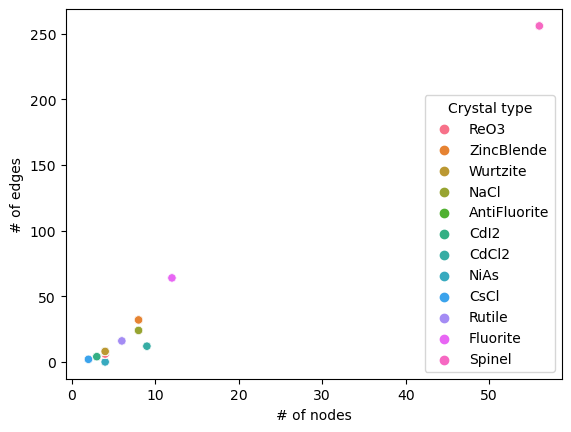

In [20]:
sns.scatterplot(data=stats, x='# of nodes', y='# of edges', hue='Crystal type')
plt.show()

In [59]:
palette = sns.color_palette('tab10')
color_dict = {'Train': palette[0], 'Validation': palette[1], 'Test': palette[2]}
hue_order = ['Train', 'Validation', 'Test']

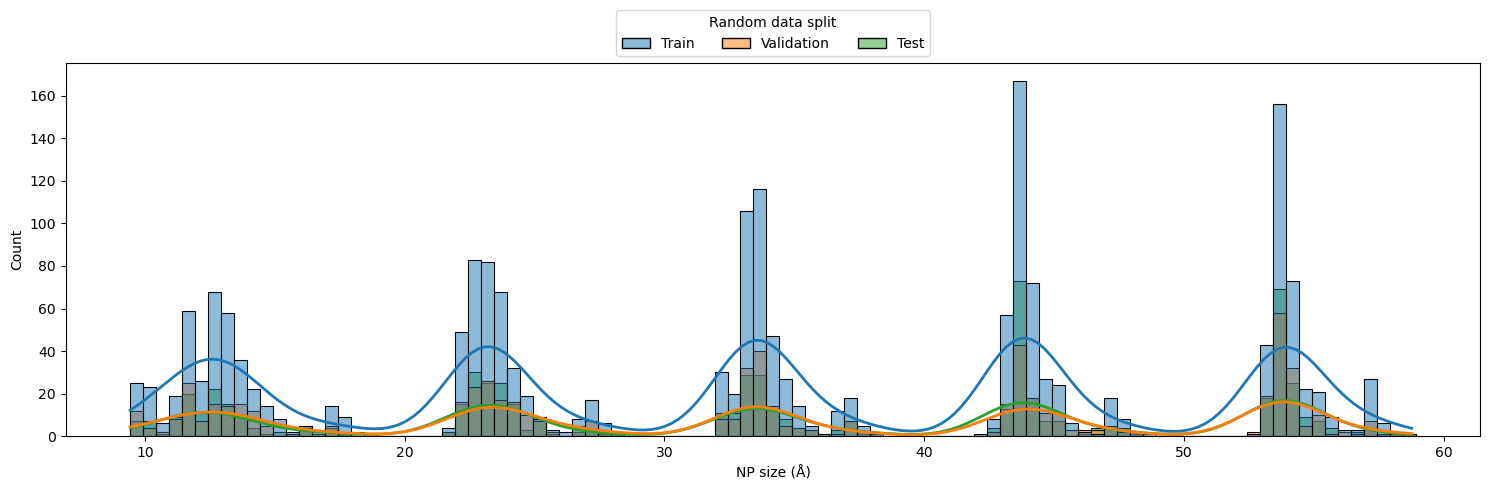

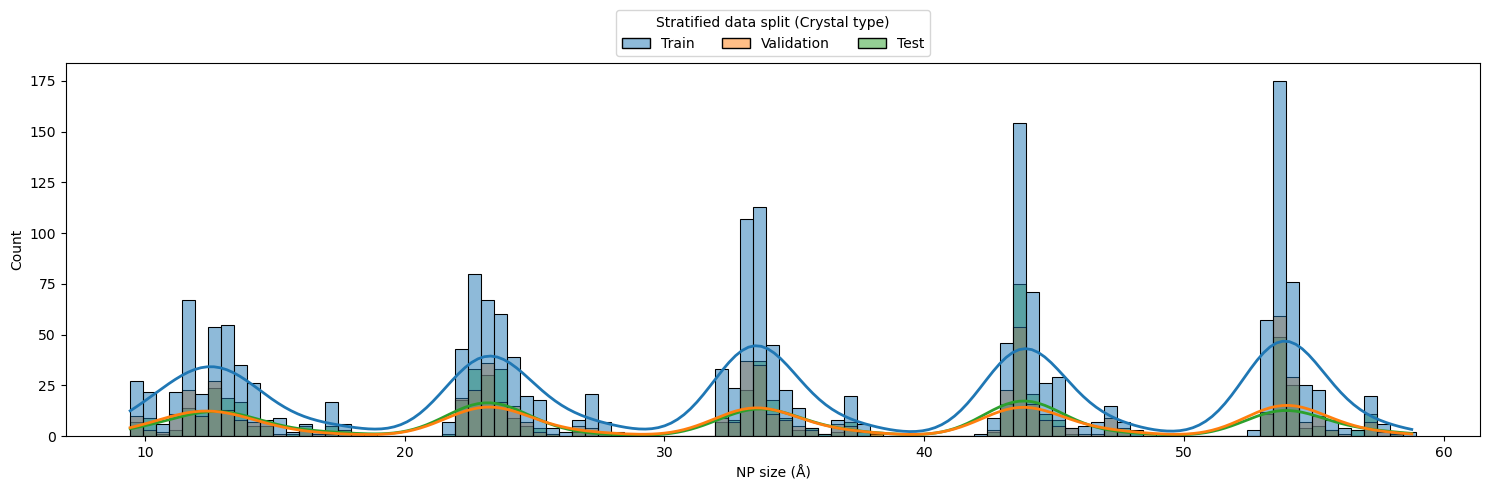

In [72]:
plt.figure(figsize=(15,5))
ax = sns.histplot(data=stats, x='NP size (Å)', binwidth=0.5, hue='Random data split', multiple='layer',kde=True, kde_kws=dict(bw_method=0.1), line_kws=dict(linewidth=2), stat='count', palette=color_dict, hue_order=hue_order)
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.tight_layout()
# plt.savefig('./test_stats_sizeDist.png', format='png', dpi=300)
plt.show()

plt.figure(figsize=(15,5))
ax = sns.histplot(data=stats, x='NP size (Å)', binwidth=0.5, hue='Stratified data split (Crystal type)', multiple='layer',kde=True, kde_kws=dict(bw_method=0.1), line_kws=dict(linewidth=2), stat='count', palette=color_dict, hue_order=hue_order)
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.tight_layout()
# plt.savefig('./test_stats_sizeDist.png', format='png', dpi=300)
plt.show()

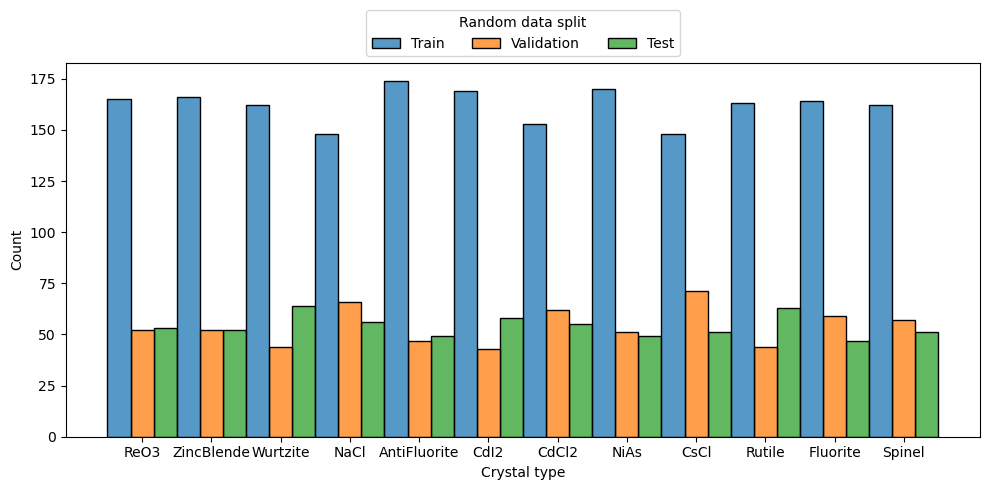

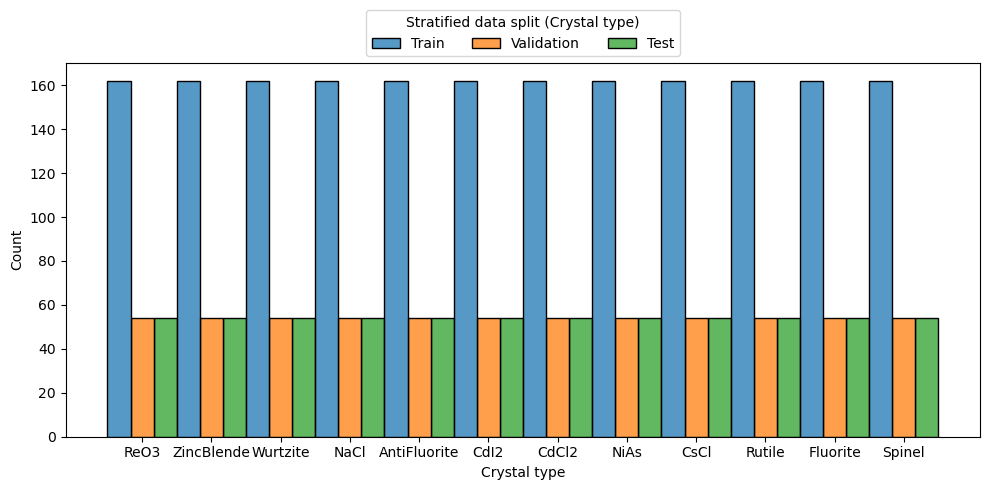

In [62]:
plt.figure(figsize=(10,5))
ax = sns.histplot(data=stats, x='Crystal type', hue='Random data split', multiple='dodge', palette=color_dict, hue_order=hue_order)
# ax = sns.histplot(data=stats, x='Crystal type', hue='Stratified data split (Crystal type)', multiple='dodge', palette=color_dict, hue_order=hue_order)
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.tight_layout()
# plt.savefig('./test_stats_crystalTypes.png', format='png', dpi=300)
plt.show()

plt.figure(figsize=(10,5))
#ax = sns.histplot(data=stats, x='Crystal type', hue='Random data split', multiple='dodge', palette=color_dict, hue_order=hue_order)
ax = sns.histplot(data=stats, x='Crystal type', hue='Stratified data split (Crystal type)', multiple='dodge', palette=color_dict, hue_order=hue_order)
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.tight_layout()
# plt.savefig('./test_stats_crystalTypes.png', format='png', dpi=300)
plt.show()

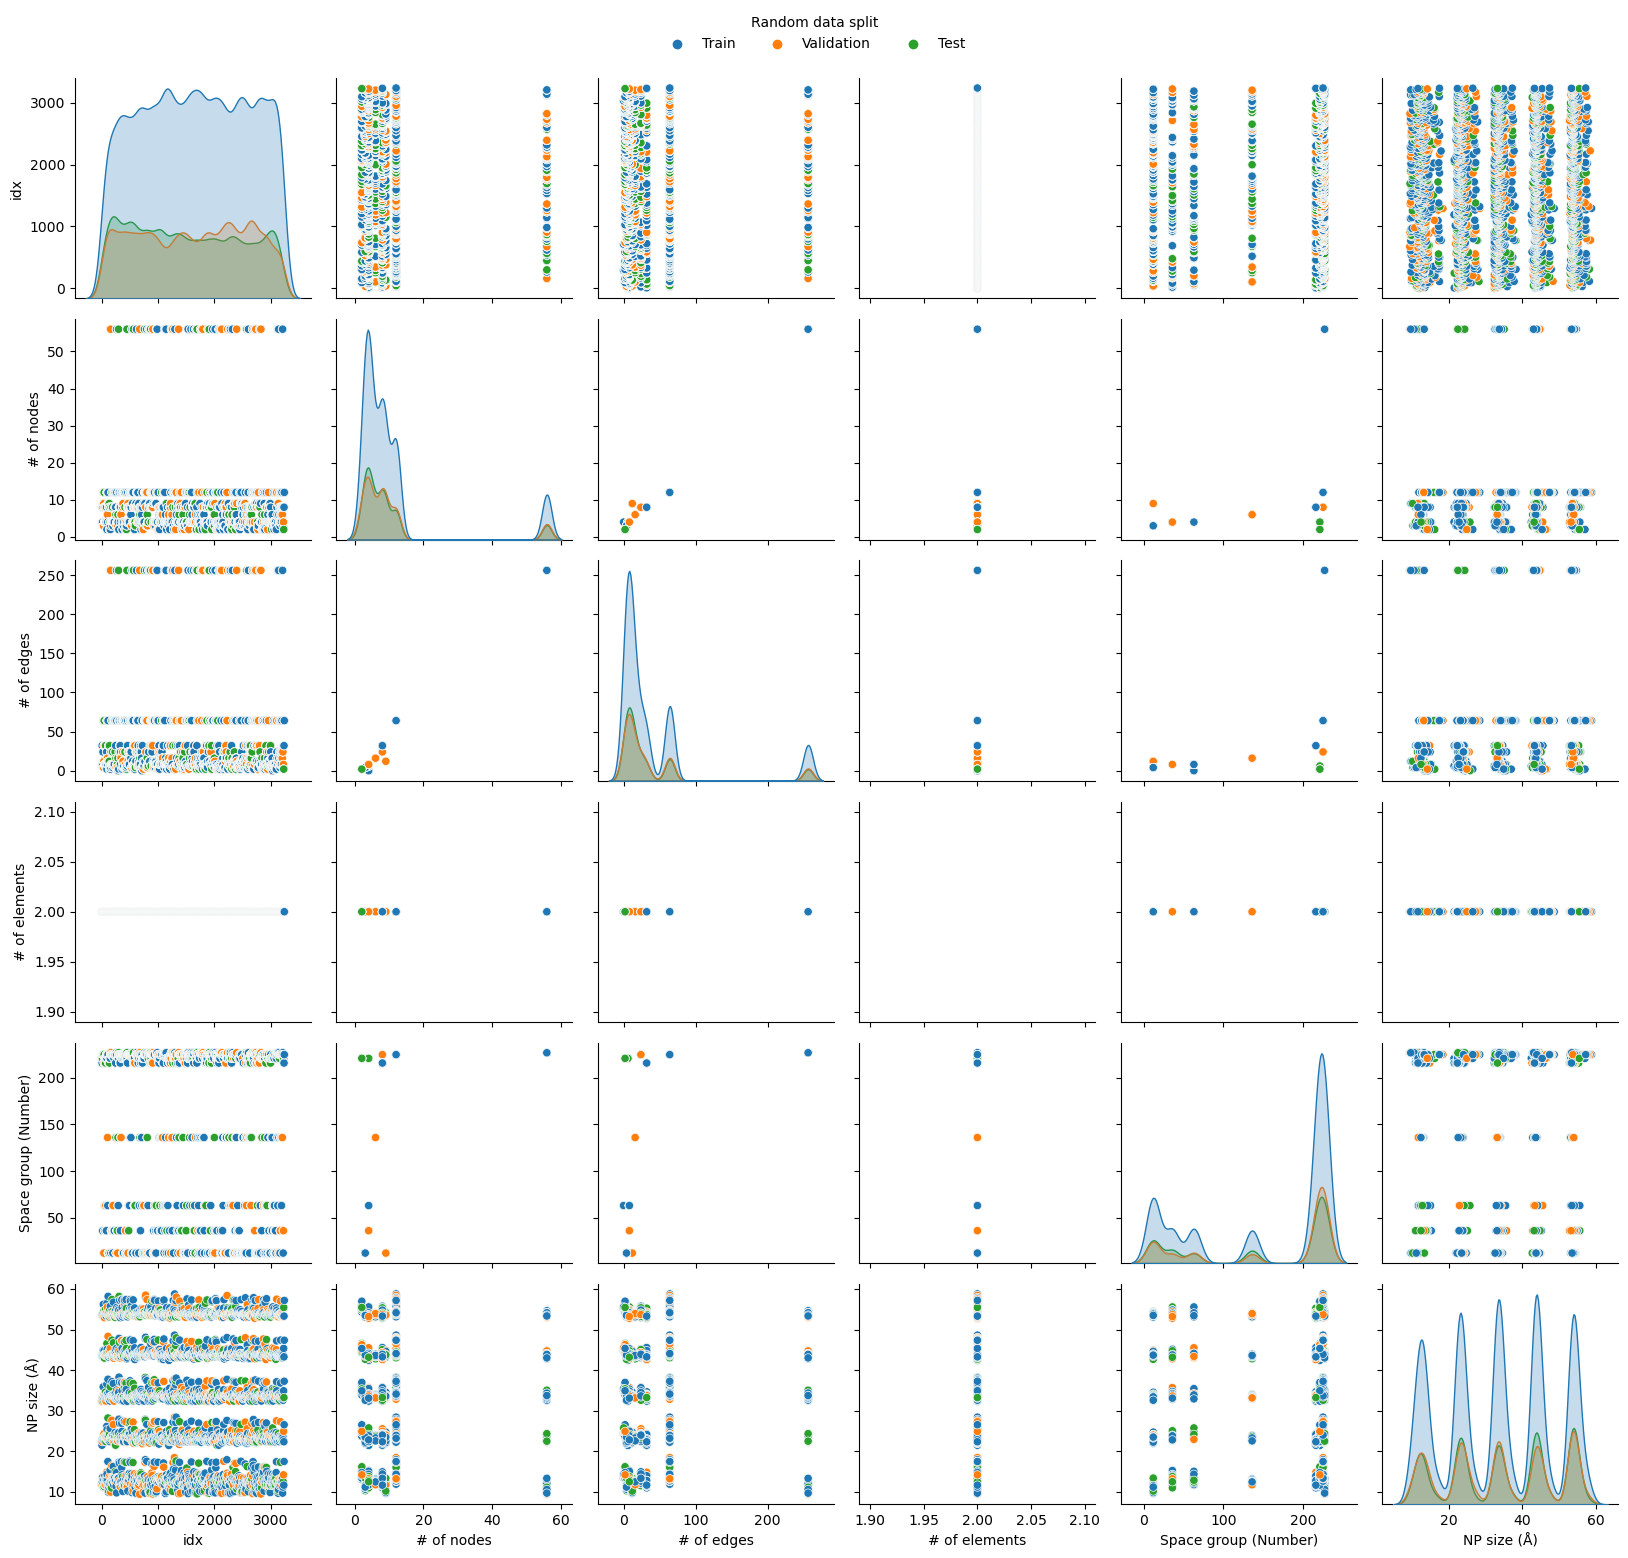

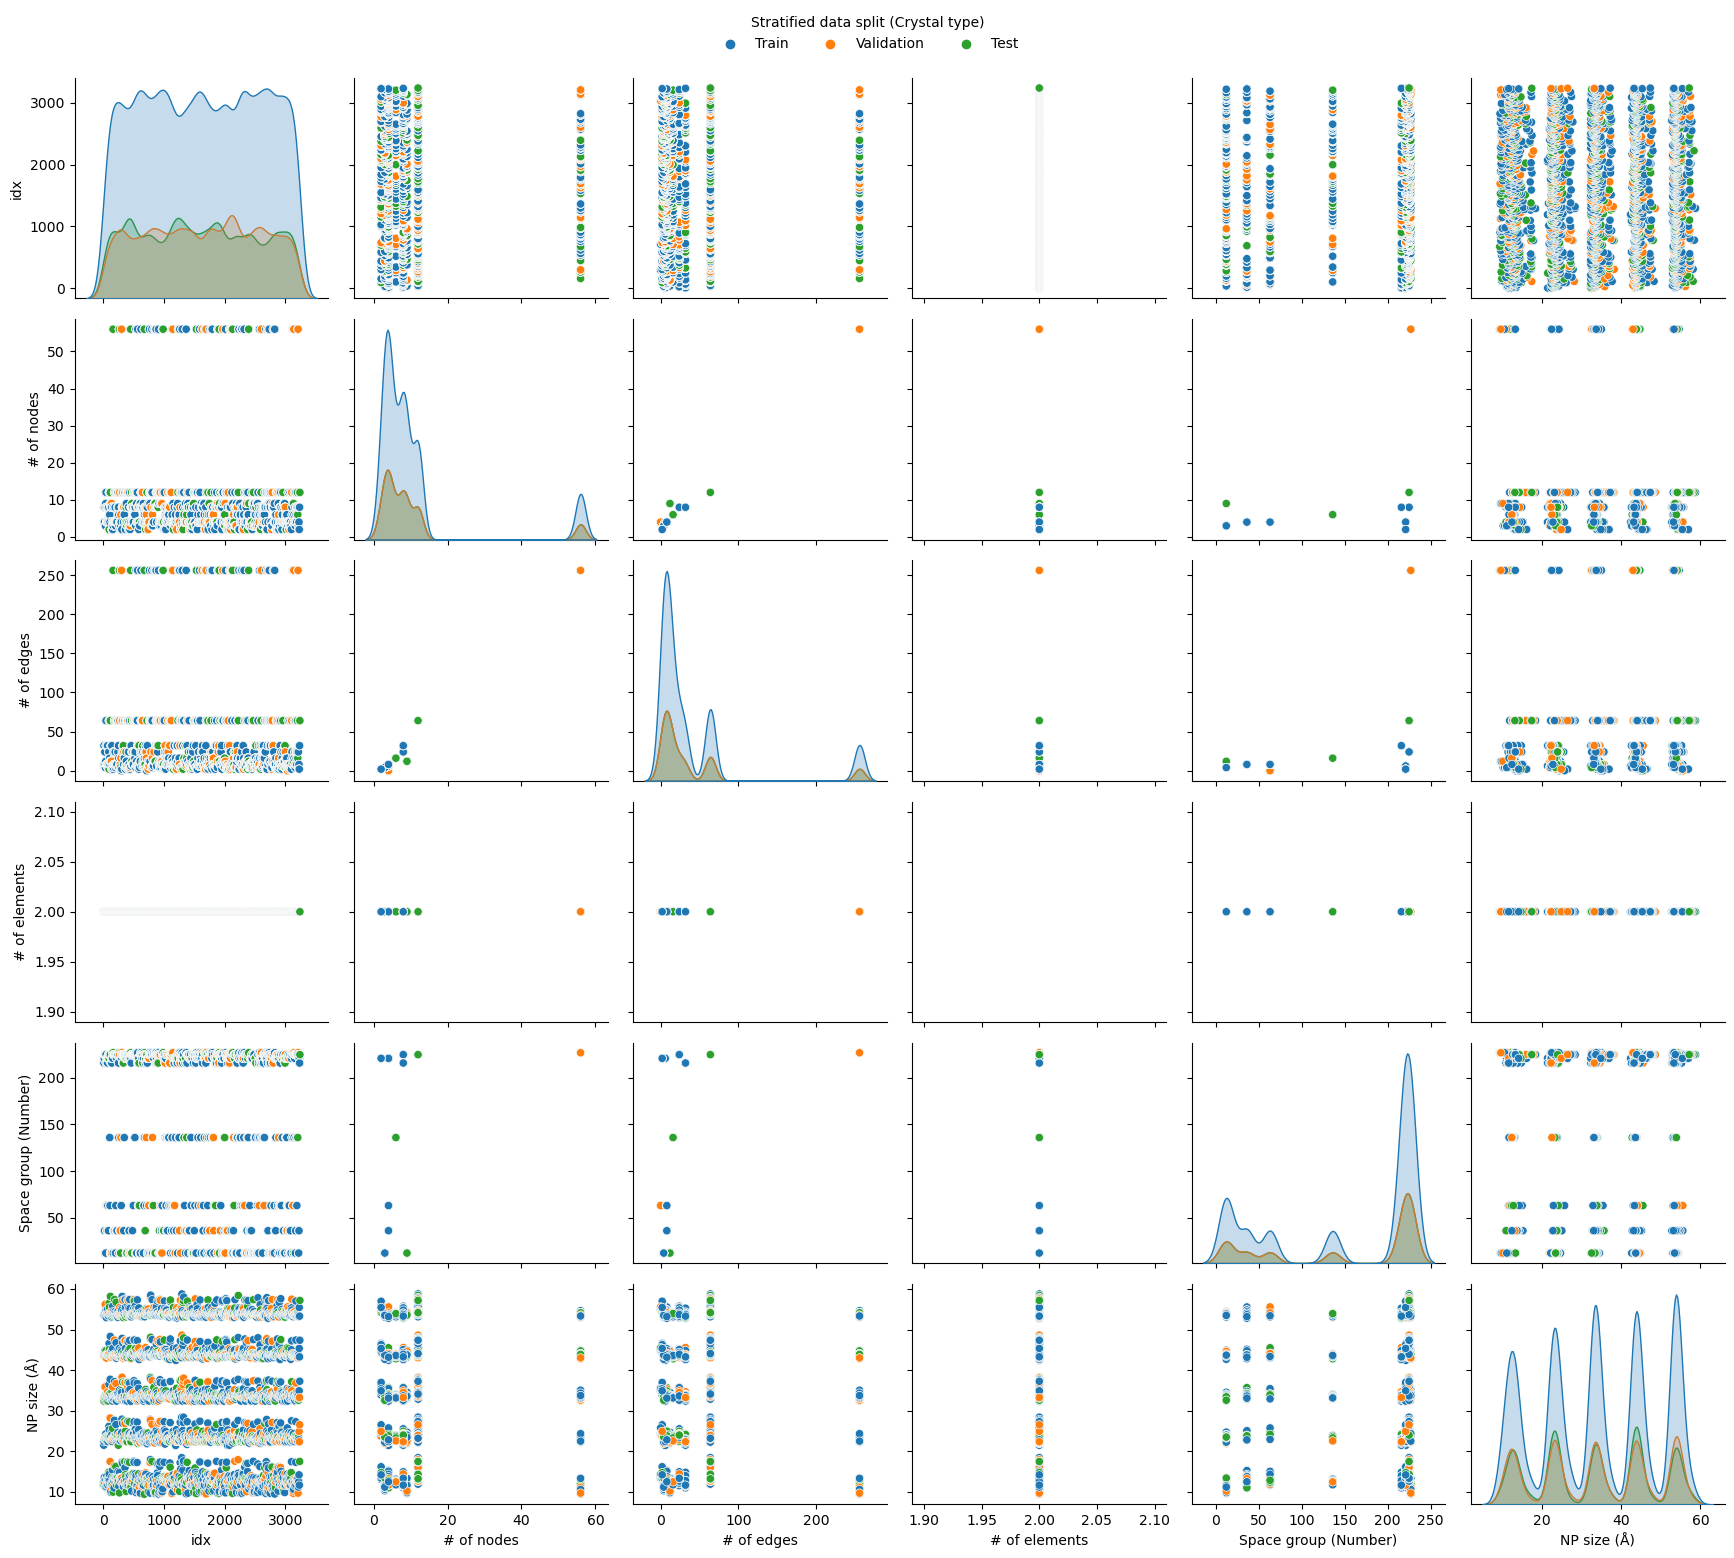

In [74]:
ax = sns.pairplot(data=stats.drop('Elements', axis=1), hue='Random data split', diag_kws=dict(bw_method=0.1), palette=color_dict, hue_order=hue_order)
# ax = sns.pairplot(data=stats.drop('Elements', axis=1), hue='Stratified data split (Crystal type)', diag_kws=dict(bw_method=0.1), palette=color_dict, hue_order=hue_order)
# ax = sns.pairplot(data=stats.drop('Elements', axis=1), diag_kws=dict(bw_method=0.1))
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.tight_layout()
# plt.savefig('./test_stats_pairplot.png', format='png', dpi=300)
plt.show()

#ax = sns.pairplot(data=stats, hue='Random data split', diag_kws=dict(bw_method=0.1))
ax = sns.pairplot(data=stats.drop('Elements', axis=1), hue='Stratified data split (Crystal type)', diag_kws=dict(bw_method=0.1), palette=color_dict, hue_order=hue_order)
# ax = sns.pairplot(data=stats.drop('Elements', axis=1), diag_kws=dict(bw_method=0.1))
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.tight_layout()
# plt.savefig('./test_stats_pairplot.png', format='png', dpi=300)
plt.show()

In [25]:
stats.columns

Index(['idx', '# of nodes', '# of edges', '# of elements',
       'Space group (Symbol)', 'Space group (Number)', 'Crystal type',
       'NP size (Å)', 'Elements', 'Random data split',
       'Stratified data split (Crystal type)'],
      dtype='object')